## LuTan-1 interferometric processing

Relevant links:
+ Urgent response from CASC: https://mp.weixin.qq.com/s/SuFf4t91nyfaQo6CXC-QuQ

In [14]:
%matplotlib inline
import os
import platform
import shutil
import numpy as np
from matplotlib import pyplot as plt
from mintpy.utils import readfile, writefile, isce_utils
from mintpy.cli import geocode, mask, subset, view
from skimage.transform import resize
plt.rcParams.update({'font.size': 12})

if platform.system() == 'Linux':
    proj_dir = os.path.expanduser('~/data/2023TurkeyEQ')
else:
    proj_dir = os.path.expanduser('~/data/archives/2023TurkeyEQ')
data_dir = os.path.join(proj_dir, 'SAR/LT1_D068/SLCprocess')
work_dir = os.path.join(proj_dir, 'LT1_D068_20220411_20230210')
os.chdir(work_dir)
print('Go to directory:', work_dir)

dname = os.path.basename(work_dir)

# input / output files
geom_file = os.path.join(work_dir, 'geometryGeo.h5')
int_file = os.path.join(work_dir, 'filt_fine.int')
coh_file = os.path.join(work_dir, 'filt_fine.cor')
unw_file = os.path.join(work_dir, 'filt_fine.unw')
conncomp_file = os.path.join(work_dir, 'filt_fine.unw.conncomp')

dem_file = os.path.join(proj_dir, 'DEM/demLat_N35_N42_Lon_E034_E041_90m.h5')
flt_file = os.path.join(proj_dir, 'USGS/simple_fault_confident.lonlat')

Go to directory: /Users/yunjunz/data/archives/2023TurkeyEQ/LT1_D068_20220411_20230210


In [3]:
def get_nonzero_row_number(data, buffer=2):
    """Find the first and last row number of rows without zero value
    for multiple swaths data

    Copied from mintpy.utils.isce_utils.extract_geometry_metadata.get_nonzero_row_number()
    """ 
    if np.all(data):
        r0, r1 = 0 + buffer, -1 - buffer
    else:
        row_flag = np.sum(data != 0., axis=1) > 0
        row_idx = np.where(row_flag)[0] 
        r0, r1 = row_idx[0] + buffer, row_idx[-1] - buffer
    return r0, r1

### 1. Stitch multiple segments into one

In [26]:
int_files = [os.path.join(data_dir, f'seg{x}/B_A.diff') for x in range(1,9)]
rsc_file = os.path.join(data_dir, 'B_A.diff.rsc')
atr = readfile.read_roipac_rsc(rsc_file)
length, width = int(atr['LENGTH']), int(atr['WIDTH'])

In [27]:
coh = np.zeros((length, width), dtype=np.float32)
pha = np.zeros((length, width), dtype=np.float32)
for int_file in int_files:
    if not os.path.isfile(int_file + '.rsc'):
        shutil.copy2(rsc_file, os.path.dirname(int_file))

    print(f'stitching file {int_file}')
    coh_data = readfile.read(int_file, datasetName='magnitude')[0]
    pha_data = readfile.read(int_file, datasetName='phase')[0]
    r0, r1 = get_nonzero_row_number(coh_data)
    coh[r0:r1,:] = coh_data[r0:r1,:]
    pha[r0:r1,:] = pha_data[r0:r1,:]

# final cut
r0, r1 = get_nonzero_row_number(coh)
coh = coh[r0:r1,:]
pha = pha[r0:r1,:]

stitching file /home/yunjunz/data/2023TurkeyEQ/SAR/LT1_D068/SLCprocess/seg1/B_A.diff
~pi boundary value (3.1415927) detected, convert to zero
stitching file /home/yunjunz/data/2023TurkeyEQ/SAR/LT1_D068/SLCprocess/seg2/B_A.diff
~pi boundary value (3.1415927) detected, convert to zero
stitching file /home/yunjunz/data/2023TurkeyEQ/SAR/LT1_D068/SLCprocess/seg3/B_A.diff
~pi boundary value (3.1415927) detected, convert to zero
stitching file /home/yunjunz/data/2023TurkeyEQ/SAR/LT1_D068/SLCprocess/seg4/B_A.diff
~pi boundary value (3.1415927) detected, convert to zero
stitching file /home/yunjunz/data/2023TurkeyEQ/SAR/LT1_D068/SLCprocess/seg5/B_A.diff
~pi boundary value (3.1415927) detected, convert to zero
stitching file /home/yunjunz/data/2023TurkeyEQ/SAR/LT1_D068/SLCprocess/seg6/B_A.diff
~pi boundary value (3.1415927) detected, convert to zero
stitching file /home/yunjunz/data/2023TurkeyEQ/SAR/LT1_D068/SLCprocess/seg7/B_A.diff
~pi boundary value (3.1415927) detected, convert to zero
stitch

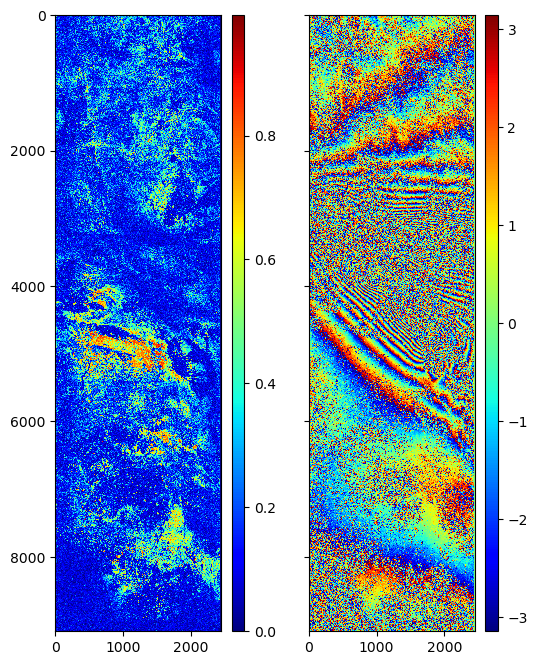

In [28]:
# plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[6, 8], sharey=True)
for ax, data in zip(axs, [coh, pha]):
    im = ax.imshow(data, cmap='jet', interpolation='nearest')
    fig.colorbar(im, ax=ax, aspect=50)
plt.show()

In [50]:
# prepare metadata
meta = dict(atr)
meta['LENGTH'] = coh.shape[0]
meta['WIDTH'] = coh.shape[1]
meta['BANDS'] = '1'
meta['DATA_TYPE'] = 'complex64'
meta['BYTE_ORDER'] = 'little-endian'
meta['FILE_TYPE'] = '.int'
meta['PROCESSOR'] = 'isce'

# prepare int data
int_data = coh * np.exp(-1j * pha)
writefile.write_isce_file(int_data, out_file=int_file, file_type='isce_int')
writefile.write_roipac_rsc(meta, int_file+'.rsc')

write file: /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.int.xml
write file: /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.int.vrt


'/home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.int.rsc'

### 2. Prepare lookup table files in isce-2 format

delete exsited file: /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/geometryGeo.h5
create HDF5 file: /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/geometryGeo.h5 with w mode
create dataset /rangeCoord   of float32    in size of (16858, 8607)        with compression=None
create dataset /azimuthCoord of float32    in size of (16858, 8607)        with compression=None
finished writing to /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/geometryGeo.h5
view.py ./geometryGeo.h5 --figsize 9 6 --noverbose


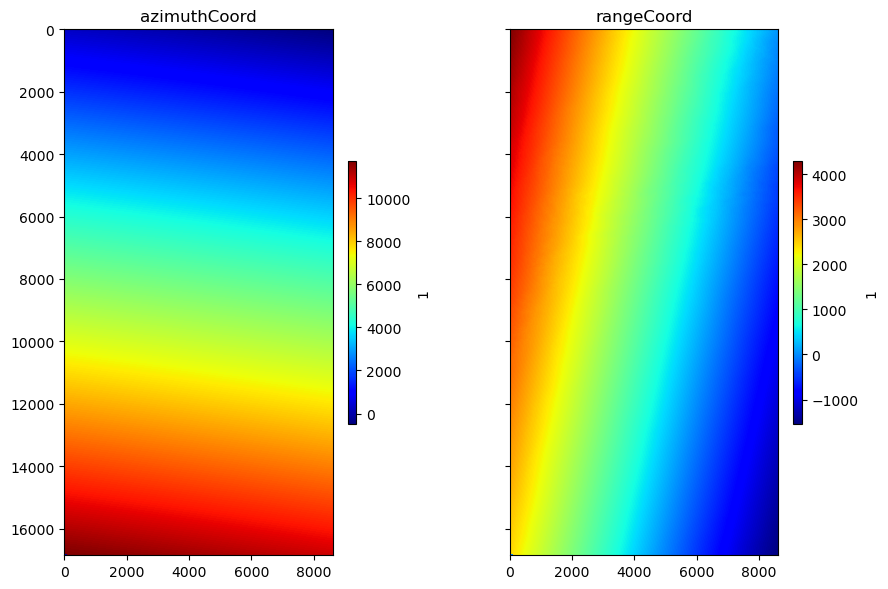

In [25]:
lut_file = os.path.join(data_dir, 'dem/lookup_table.eqa_2_rdc')
atr = readfile.read_attribute(lut_file)
atr['BANDS'] = '2'
atr['INTERLEAVE'] = 'BIP'
atr['DATA_TYPE'] = 'float32'
atr['BYTE_ORDER'] = 'big-endian'
writefile.write_roipac_rsc(atr, lut_file+'.rsc')

# write to geometryGeo.h5
rg_coord = readfile.read(lut_file, datasetName='rangeCoord')[0].astype(np.float32)
az_coord = readfile.read(lut_file, datasetName='azimuthCoord')[0].astype(np.float32)
ds_dict = {'rangeCoord' : rg_coord, 'azimuthCoord' : az_coord}
atr['BYTE_ORDER'] = 'little-endian'
writefile.write(ds_dict, out_file=geom_file, metadata=atr)

# plot
view.main('./geometryGeo.h5 --figsize 9 6 --noverbose'.split())

### 3. Estimate coherence (phase sigma)

In [31]:
isce_utils.estimate_coherence(int_file, coh_file)

GDAL open (R): /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.int.vrt
API open (WR): /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.cor

 << PS filtering >>


 interferogram width:  2452  number of lines/patch:  3700
 start line:        1  number of lines:    9100
 start sample:      1  end sample:         2452
 wisdomFile, length =            0

 azimuth buffer size:                             3700
 overlap between azimuth patches:                  200
 total overlap between azimuth patches:            264
 offset in overlap region for phase  bootstrap:    132
 lines to increment for the next patch:           3436
 number of patches:                                  3

 PATCH:   1   starting line:     0    lines read: 3700
 starting output line:    1   ending output line: 3568

 PATCH:   2   starting line:  3436    lines read: 3700
 starting output line:  133   ending output line: 3568

 PATCH:   3   starting line:  6872    lines read: 2228

### 4. Phase unwrap

In [51]:
meta = readfile.read_roipac_rsc(int_file+'.rsc')
meta['BANDS'] = '2'
meta['DATA_TYPE'] = 'float32'
meta['FILE_TYPE'] = '.unw'
writefile.write_roipac_rsc(meta, unw_file+'.rsc')

'/home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.unw.rsc'

In [35]:
cmd = f'unwrap.py -i {int_file} -c {coh_file} -o {unw_file} --comp-max 20 --defo-max 10 --init-only --init-method MCF --cost-mode DEFO'
print(cmd)

unwrap.py -i /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.int -c /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.cor -o /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.unw --comp-max 20 --defo-max 10 --init-only --init-method MCF --cost-mode DEFO


### 5. Mask + Geocode

In [77]:
#mask.main(f'{unw_file} -m {unw_file}.conncomp'.split())

fbase = os.path.splitext(unw_file)[0]
cmd = f'{fbase}.int {fbase}.cor {fbase}_msk.unw -l {geom_file} --fill nan'
print(f'geocode.py {cmd}')
#geocode.main(cmd.split())

S, N, W, E = 35.3, 39.0, 35.0, 39.5   # same as Fig. 1
cmd = f'geo_filt_fine_msk.unw --lat {S} {N} --lon {W} {E} --outfill nan'
print(f'subset.py {cmd}')
#subset.main(cmd.split())

geocode.py /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.int /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.cor /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine_msk.unw -l /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/geometryGeo.h5 --fill nan
subset.py geo_filt_fine_msk.unw --lat 35.3 39.0 --lon 35.0 39.5 --outfill nan
------------------------------
subset .unw file: geo_filt_fine_msk.unw ...
data   range in (x0,y0,x1,y1): (0, 0, 8607, 16858)
subset range in (x0,y0,x1,y1): (-4496, 1741, 11704, 15061)
data   range in (W, N, E, S): (36.2488889, 39.4836111, 38.63972225246, 34.800833284759996)
subset range in (W, N, E, S): (35.00000000112, 38.99999998502, 39.500000037119996, 35.29999995542)
writing >>> sub_geo_filt_fine_msk.unw
update LENGTH, WIDTH, Y/XMAX
update/add SUBSET_XMIN/YMIN/XMAX/YMAX: -4496/1741/11704/15061
update Y/X_FIRST
reading magnitude in (0, 1741, 8607, 15061) from geo_filt_fine_msk.unw ...
read

run view.py in MintPy version 1.5.1.post44, date 2023-06-20
input file is isce .unw file: /scratch/yunjunz/2023TurkeyEQ/LT1_D068_20220411_20230210/sub_geo_filt_fine_msk.unw in float32 format
file size in y/x: (13320, 16200)
input dataset: "['phase']"
num of datasets in file sub_geo_filt_fine_msk.unw: 2
datasets to exclude (0):
[]
datasets to display (1):
['phase']
data   coverage in y/x: (0, 0, 16200, 13320)
subset coverage in y/x: (0, 0, 16200, 13320)
data   coverage in lat/lon: (35.00000000112, 38.99999998502, 39.50000003712, 35.29999995542)
subset coverage in lat/lon: (35.00000000112, 38.99999998502, 39.50000003712, 35.29999995542)
------------------------------------------------------------------------
area exceed 2000 pixels, turn off default DEM contour display
colormap: RdBu
initiate cartopy map projection: PlateCarree
figure title: LT1_D068_20220411_20230210_IFG
figure size : [9.12, 6.00]
reading data ...
Apply math operation: reverse
data    range: [-4.338081, 0.31272516] m
di

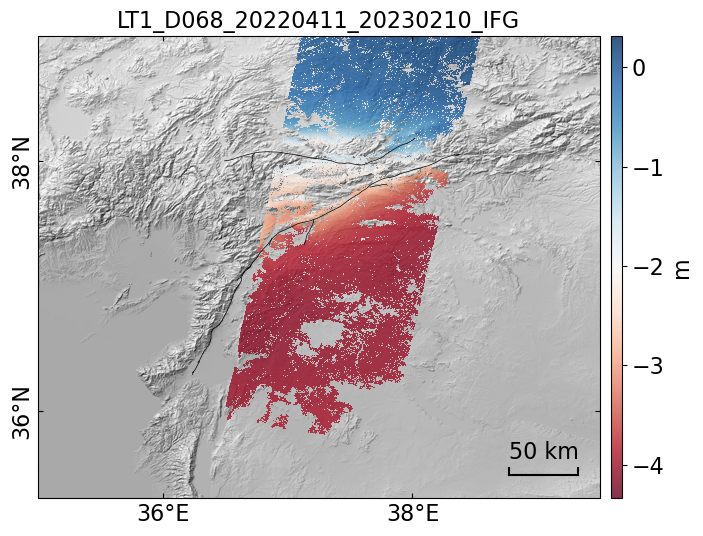

In [80]:
# plot
unw_file = 'sub_geo_filt_fine_msk.unw'
out_file = os.path.join(proj_dir, f'notebooks/docs/{dname}_IFG.png')
cmd = f'{unw_file} phase --dem {dem_file} --dem-nocontour --shade-exag 0.05 --faultline {flt_file} '
cmd += f'-c RdBu -u m --lalo-label --lalo-step 2 --ylabel-rot 90 --cbar-nbins 5 '
cmd += f'--scalebar 0.12 0.90 0.05 --title {dname}_IFG --ref-size 4 --math reverse '
cmd += f'-o {out_file} '
view.main(cmd.split())

In [17]:
pha, atr = readfile.read('sub_geo_filt_fine_msk.unw', datasetName='phase')

ref_unw_file = os.path.join(proj_dir, 'ALOS2_D077_20220916_20230217/insar/geo/geo_filt_msk.unw')
ref_pha0, ref_atr = readfile.read(ref_unw_file, datasetName='phase')
ref_pha = resize(np.array(ref_pha0), pha.shape, order=1, mode='constant', anti_aliasing=True, preserve_range=True)

/Users/yunjunz/tools/mambaforge/envs/insar/lib/python3.10/site-packages/matplotlib/image.py:484: RuntimeWarning: overflow encountered in subtract
  A_scaled -= a_min
/Users/yunjunz/tools/mambaforge/envs/insar/lib/python3.10/site-packages/matplotlib/image.py:485: RuntimeWarning: overflow encountered in subtract
  vrange -= a_min


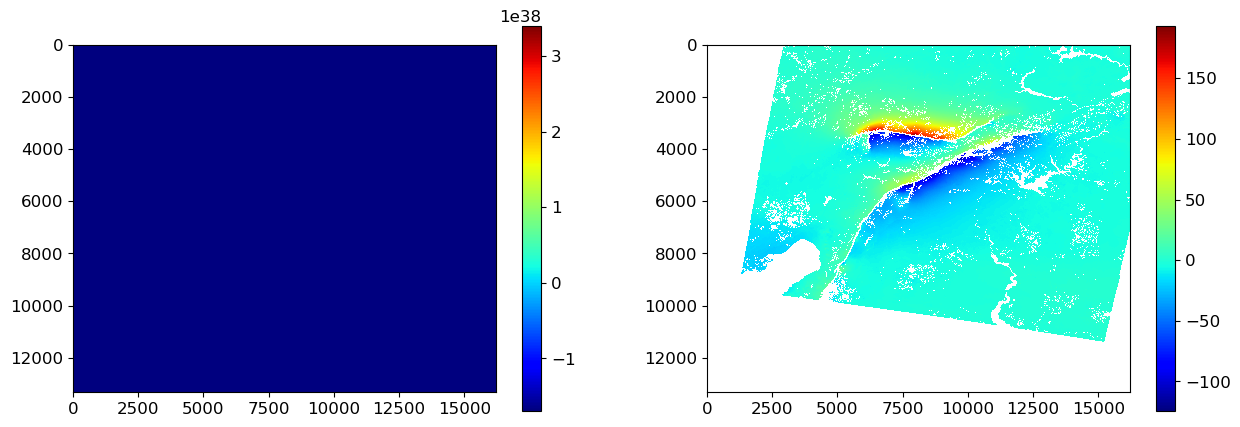

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[15,5])
for ax, data in zip(axs, [pha, ref_pha]):
    im = ax.imshow(data, cmap='jet', interpolation='nearest')
    fig.colorbar(im, ax=ax)
plt.show()

In [13]:
pha.shape, ref_pha.shape

((13320, 16200), (4440, 5400))

### Backup: get bperp

P_BASELINE_BOTTOM_HDR: -564.51 m
P_BASELINE_TOP_HDR: -542.05 m


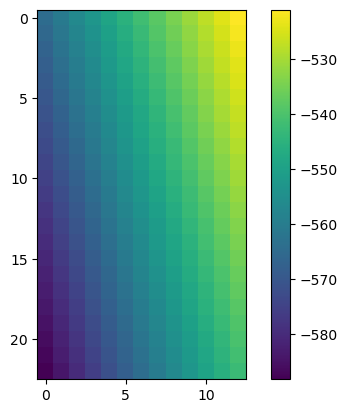

In [74]:
# read perp_baseline
bperp_file = os.path.join(data_dir, 'B_A.bperp')
num_row = int(11000 / 500 + 1)
num_col = int(2400 / 200 + 1)
bperp = np.loadtxt(bperp_file, usecols=[7], skiprows=12, max_rows=299).reshape(num_row, num_col)

print(f'P_BASELINE_BOTTOM_HDR: {np.mean(bperp[-1,:]):.2f} m')
print(f'P_BASELINE_TOP_HDR: {np.mean(bperp[0,:]):.2f} m')

# plot
plt.figure()
plt.imshow(bperp)
plt.colorbar()
plt.show()